In this notebook I will try to implement and analyze LDA algorithm using PyMC package. The implementation is replication of the code provided at: http://stats.stackexchange.com/questions/104771/latent-dirichlet-allocation-in-pymc

The LDA model is described below:
![LDA Model](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d3/Latent_Dirichlet_allocation.svg/250px-Latent_Dirichlet_allocation.svg.png)

In [1]:
import numpy as np
import pymc as pm
#K, V, D = 2, 4, 3 # number of topics, words, documents
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
%matplotlib inline

In [31]:
K, V, D = 5, 10, 20 # number of topics, words, documents

#data = np.array([[1, 1, 1, 1], [1, 1, 1, 1], [0, 0, 0, 0]])

data_temp = np.random.randint(0,10,size=(D,V))

In [33]:
class LDA(object):
    
    def __init__(self, data, topics=K, vocab=V):
        """
        Takes the data variable and outputs a model
        """
        self.data = data
        self.topics = topics
        self.vocab = vocab+1
        self.docs = len(self.data)
        self.alpha = np.ones(self.topics)
        self.beta = np.ones(self.vocab)

        self.theta = pm.Container([pm.CompletedDirichlet("theta_%s" % i,\
                                                         pm.Dirichlet("ptheta_%s" % i, theta=self.alpha))
                                   for i in range(self.docs)])
        self.phi = pm.Container([pm.CompletedDirichlet("phi_%s" % i,\
                                                       pm.Dirichlet("pphi_%s" % i, theta=self.beta))
                                 for i in range(self.topics)])
        self.Wd = [len(doc) for doc in self.data]

        self.Z = pm.Container([pm.Categorical("z_%s" % d, 
                                              p=self.theta[d],
                                              size=self.Wd[d],
                                              value=np.random.randint(self.topics,size=self.Wd[d]))
                               for d in range(self.docs)])
        self.W = pm.Container([pm.Categorical("w_%s,%s" % (d,i),
                                              p=pm.Lambda("phi_z_%s_%s" % (d,i), 
                                                          lambda z=self.Z[d][i], phi=self.phi: phi[z]),
                                              value=self.data[d][i],
                                              observed=True)
                               for d in range(self.docs) for i in range(self.Wd[d])])

        self.model = pm.Model([self.theta, self.phi, self.Z, self.W])
        self.mcmc = pm.MCMC(self.model)
    
    def fit(self, iterations=1000, burn_in=10):
        # Fit the model by sampling from the data iterations times with burn in of burn_in.
        self.mcmc.sample(iterations, burn=burn_in)
        
    def show_topics(self):
        # Show distribution of topics over words
        return self.phi.value
    
    def show_words(self):
        # Show distribution of words in documents over topics
        return self.W.value
    
    def KLDiv(self, p,q):
        return np.sum(p*np.log10(p/q))
    
    def cosine_sim(self, x,y):
        return np.dot(x,y)/np.sqrt(np.dot(x,x)*np.dot(y,y))
    
    def sorted_docs_sim(self):
        kldivs_docs = [(i, j, self.KLDiv(self.theta[i].value,self.theta[j].value),
                        self.cosine_sim(self.data[i], self.data[j]))
                       for i in range(len(self.theta)) for j in range(len(self.theta))
                       if i != j]
        return sorted(kldivs_docs, key=lambda x: x[3], reverse=True)
    
    def plot_words_per_topic(self, ax=None):
        if ax is None:
            plt.clf()
            fig, ax = plt.subplots(1,1)
        words = self.Z.value
        topic_dist = dict()
        for k_i in words:
            for k in k_i:
                if k not in topic_dist:
                    topic_dist[k] = 0
                topic_dist[k] += 1
        ax.bar(topic_dist.keys(), topic_dist.values())
        ax.set_xlabel("Topics")
        ax.set_ylabel("Counts")
        ax.set_title("Document words per topics")
        plt.show()
        
    def plot_word_dist(self, ax=None):
        topics = self.phi.value
        if ax is None:
            plt.clf()
            fig, ax = plt.subplots((len(topics)+1)/2, 2, figsize=(10,10))
        for i, t in enumerate(topics):
            ax[i/2][i%2].bar(range(len(t[0])), t[0])
            ax[i/2][i%2].set_title("Topic %s" % i)
        plt.suptitle("Vocab word proportions per topic")
        fig.subplots_adjust(hspace=0.5, wspace=0.5)

 [-----------------100%-----------------] 1000 of 1000 complete in 39.4 sec

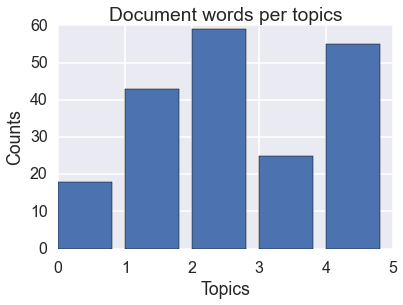

In [34]:
lda = LDA(data_temp)
lda.fit()
lda.plot_words_per_topic()

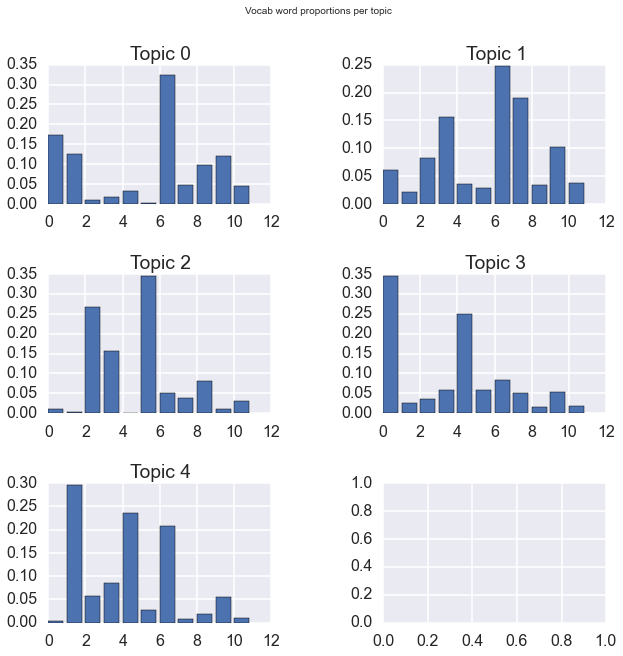

In [5]:
lda.plot_word_dist()

In [6]:
kld_sorted = lda.sorted_docs_sim()
kld_sorted[:10]

[(11, 12, 0.12794402850656339, 0.91550703216514051),
 (12, 11, 0.23233086565032021, 0.91550703216514051),
 (7, 16, 0.069081961101030681, 0.91529433139300531),
 (16, 7, 0.084241263235092026, 0.91529433139300531),
 (11, 14, 0.11389710569477, 0.89897158850740189),
 (14, 11, 0.11807633003998763, 0.89897158850740189),
 (0, 15, 0.27583826339271433, 0.89552039314012999),
 (15, 0, 0.22658878049302303, 0.89552039314012999),
 (8, 16, 0.20735934380211171, 0.88181818181818183),
 (16, 8, 0.28884846182266505, 0.88181818181818183)]

# REAL DATA
Now lets move to trying on some real world data. I will use the reuters corpus.

In [7]:
from nltk.corpus import inaugural
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

In [8]:
# Create a vocabulary from the corpus
vocab = dict()
for fileid in inaugural.fileids():
    for word in inaugural.words(fileid):
        word = word.lower()
        if word not in stops and word.isalpha():
            if word not in vocab:
                vocab[word] = 0
            vocab[word] += 1

In [12]:
"""
Sort the vocab keep only words which occur more than 50 times
Then Create word to id and id to word dictionaries
"""
vocab_sorted = filter(lambda x: x[1] > 50, sorted(vocab.items(), key=lambda x: x[1], reverse=True))
wordids = {v[0]: i for i, v in enumerate(vocab_sorted)}
idwords = {i: v[0] for i, v in enumerate(vocab_sorted)}
vocab_size = len(wordids)
print vocab_size

191


In [13]:
# Generate corpus document vectors
data = []
for fileid in inaugural.fileids():
    data.append([0]*vocab_size)
    for word in inaugural.words(fileid):
        word = word.lower()
        if word in wordids:
            data[-1][wordids[word]] += 1

len(data)

56

[8, 4, 1, 0, 3, 6, 3, 1, 2, 3]


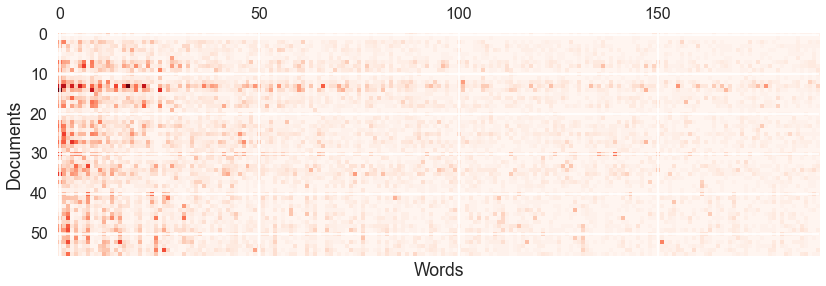

In [14]:
# Plot the document word matrix
print data[0][:10]
data = np.array(data)
plt.clf()
plt.matshow(data, fignum=1000, cmap=plt.cm.Reds)
plt.gca().set_aspect('auto')
plt.xlabel("Words")
plt.ylabel("Documents")

In [15]:
inaugural_lda = LDA(data, topics=10, vocab=vocab_size)

 [-----------------100%-----------------] 1001 of 1000 complete in 756.2 sec

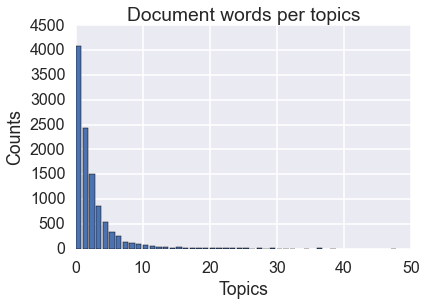

In [16]:
inaugural_lda.fit()
inaugural_lda.plot_words_per_topic()

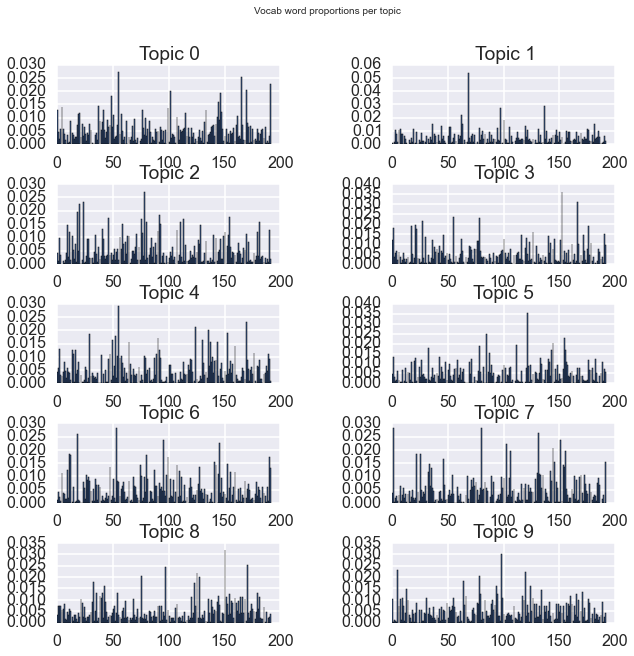

In [17]:
inaugural_lda.plot_word_dist()

In [19]:
np.max([inaugural_lda.W.value])

47

In [20]:
inaugural_lda.alpha

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [22]:
len(inaugural_lda.beta)

192

In [28]:
# Probability of each word in a topic
inaugural_lda.phi.value[0]

array([[  1.28203815e-02,   4.49603969e-03,   2.05389239e-03,
          5.87026252e-03,   1.41727947e-02,   5.58079685e-03,
          3.90101279e-03,   1.60059110e-03,   3.32651210e-05,
          3.51784721e-03,   6.49254496e-04,   7.14674099e-04,
          8.90004575e-03,   4.32536829e-03,   3.41796728e-03,
          2.01302142e-03,   2.80069488e-03,   2.65047161e-03,
          7.15933531e-03,   1.14793963e-02,   1.17350072e-02,
          2.71895938e-03,   7.68497721e-03,   3.11135199e-03,
          6.56396665e-03,   3.78883668e-03,   1.14864452e-03,
          4.44590114e-03,   3.61247836e-03,   7.47238202e-03,
          5.47253932e-03,   3.33088969e-04,   9.24865093e-05,
          2.49565270e-04,   3.52215116e-03,   4.28576576e-03,
          1.59567614e-03,   1.43041072e-02,   8.63161965e-03,
          5.27234822e-03,   8.28486857e-03,   1.27362038e-02,
          5.53056760e-03,   2.24153707e-03,   4.82137959e-03,
          9.18427484e-03,   6.60259369e-03,   7.27868347e-03,
        

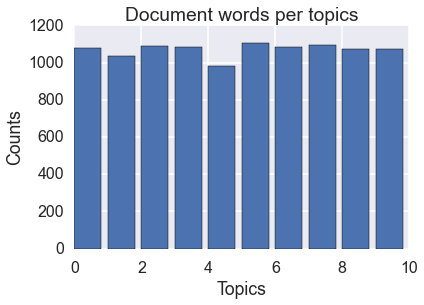

In [29]:
# Above diagram is wrong for Document words per topics

plt.clf()
fig, ax = plt.subplots(1,1)
words = inaugural_lda.Z.value
topic_dist = dict()
for k_i in words:
    for k in k_i:
        if k not in topic_dist:
            topic_dist[k] = 0
        topic_dist[k] += 1
ax.bar(topic_dist.keys(), topic_dist.values())
ax.set_xlabel("Topics")
ax.set_ylabel("Counts")
ax.set_title("Document words per topics")
plt.show()


In [41]:
for i, t in enumerate(inaugural_lda.phi.value):
    print "Topic %i : " % i, ", ".join(idwords[w_] for w_ in np.argsort(t[0])[-10:] if w_ < vocab_size -1)

Topic 0 :  must, without, subject, best, true, institutions, help, beyond, state
Topic 1 :  make, home, much, strong, spirit, interest, know, high, commerce, long
Topic 2 :  future, federal, duties, congress, seek, purpose, public, time, nations, administration
Topic 3 :  united, people, authority, power, constitution, free, administration, state, become, trust
Topic 4 :  whose, liberty, service, right, national, trust, proper, secure, help, state
Topic 5 :  far, character, security, fellow, administration, together, subject, seek, faith, things
Topic 6 :  responsibility, old, future, every, nation, called, party, public, interests
Topic 7 :  united, union, character, general, subject, always, century, americans, future, people
Topic 8 :  live, justice, might, fellow, action, duties, give, high, done, ought
Topic 9 :  done, full, peace, secure, president, god, administration, home, may, way
